In [ ]:
# 4aeb460f0c974611ef8db66c9a660e8c

In [47]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
tickers = ['XLY', 'XLP', 'XLE', 'XLK', 'XLV', 'XLF', 'XLI', 'XLB', 'XLU']
DATA_DIR = "./data"

sector_data = {}

for ticker in tickers:
    file_path = os.path.join(DATA_DIR, f"{ticker}.csv")
    df = pd.read_csv(file_path, parse_dates=["Date"])
    
    # Drop rows with missing values (e.g., dividend days)
    df = df.dropna(subset=["Adj Close"])  
    
    # Set Date as index and keep only Adjusted Close
    df = df.set_index("Date")[["Adj Close"]]
    df.rename(columns={"Adj Close": ticker}, inplace=True)
    
    sector_data[ticker] = df

# Combine into single DataFrame
etf_data = pd.concat(sector_data.values(), axis=1).sort_index()

# Preview
etf_data.head()

,XLY,XLP,XLE,XLK,XLV,XLF,XLI,XLB,XLU
Date,,,,,,,,,
2015-01-02,63.77,36.86,52.74,36.38,58.08,16.53,46.83,39.58,33.96
2015-01-05,62.55,36.60,50.55,35.82,57.78,16.18,45.74,38.57,33.55
2015-01-06,61.93,36.55,49.81,35.39,57.58,15.93,45.18,38.23,33.57
2015-01-07,62.91,37.18,49.92,35.69,58.94,16.10,45.52,38.66,33.90
2015-01-08,63.85,37.74,51.04,36.47,59.95,16.34,46.43,39.58,34.13


In [23]:
# Cell: Load SPY benchmark (same format as sectors)
spy = pd.read_csv("./data/SPY.csv", parse_dates=["Date"])
spy = spy.dropna(subset=["Adj Close"])
spy = spy.set_index("Date")[["Adj Close"]]
spy.rename(columns={"Adj Close": "SPY"}, inplace=True)

# Merge SPY with sector data
etf_data = etf_data.merge(spy, left_index=True, right_index=True, how="inner")

In [91]:
# === 1. Load ETF Data (Assumes 'etf_data' is already loaded) ===
# Ensure etf_data has monthly frequency
etf_data = etf_data.resample('M').ffill()
monthly_returns = etf_data.pct_change().dropna()

In [94]:
import pandas as pd
from fredapi import Fred

fred = Fred(api_key='4aeb460f0c974611ef8db66c9a660e8c')

macro_series = {
    'CPI': 'CPIAUCSL',          # Monthly CPI (Seasonally Adjusted)
    'Unemployment': 'UNRATE',   # Monthly Unemployment Rate
    'YieldCurve': 'T10Y2Y',     # Daily 10Y-2Y Treasury Spread
    'IndustrialProduction': 'INDPRO',  # Monthly Industrial Production
    'FedFunds': 'FEDFUNDS'      # Monthly Federal Funds Rate
}

# Fetch data from 2015-01-01 to 2024-12-31
start_date = '2015-01-01'
end_date = '2024-12-31'

dfs = []
for name, code in macro_series.items():
    try:
        data = fred.get_series(code, observation_start=start_date, observation_end=end_date)
        dfs.append(data.to_frame(name=name))
    except Exception as e:
        print(f"Failed to fetch {code}: {e}")

# Combine and resample daily data (e.g., YieldCurve) to monthly
macro_df = pd.concat(dfs, axis=1)
macro_df = macro_df.resample('M').last()  # Keep last observation per month

# Feature engineering
macro_df['YieldCurve_z'] = (
    macro_df['YieldCurve'] - macro_df['YieldCurve'].rolling(12).mean()
) / macro_df['YieldCurve'].rolling(12).std()
macro_df['CPI_change'] = macro_df['CPI'].pct_change()
macro_df['IndProd_change'] = macro_df['IndustrialProduction'].pct_change()
macro_df['FedFunds_diff'] = macro_df['FedFunds'].diff()

# Final macro features (dropna to avoid early NaNs)
macro_features = macro_df.reindex(monthly_returns.index).shift(1).dropna()

monthly_returns = monthly_returns.loc[macro_features.index]

In [98]:
# === 3. Technical Indicator Features (e.g., Momentum) ===
rolling_features = pd.DataFrame(index=monthly_returns.index)
for ticker in tickers:
    rolling_features[f'{ticker}_momentum_3'] = etf_data[ticker].pct_change(3)
    rolling_features[f'{ticker}_momentum_6'] = etf_data[ticker].pct_change(6)
    rolling_features[f'{ticker}_volatility_3'] = etf_data[ticker].pct_change().rolling(3).std()

rolling_features = rolling_features.shift(1).dropna()


In [120]:
# === 4. Combine Technical + Macro Features ===

# Align all indexes to month-end format
for df in [monthly_returns, rolling_features, macro_features]:
    df.index = pd.to_datetime(df.index).to_period("M").to_timestamp()

# Join macro features with rolling technical indicators
features = rolling_features.join(macro_features, how='inner')

# Label top N sectors each month as 1, rest as 0
top_n = 3
labels = (monthly_returns.rank(axis=1, ascending=False) <= top_n).astype(int)

# Align labels with features
features = features.loc[features.index.intersection(labels.index)]
labels = labels.loc[features.index]
monthly_returns = monthly_returns.loc[features.index]  # Align returns too

In [121]:
# === 5. Train/Test Split & Modeling ===

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Split data: use last 12 months as test
X_train, X_test = features.iloc[:-12], features.iloc[-12:]
y_train, y_test = labels.iloc[:-12], labels.iloc[-12:]

# Fit multi-label classifier
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Predict
y_pred = pd.DataFrame(model.predict(X_test), index=y_test.index, columns=y_test.columns)

# Sanity check
print("Sample Predictions:\n", y_pred.head())

Sample Predictions:
             XLY  XLP  XLE  XLK  XLV  XLF  XLI  XLB  XLU  SPY
Date                                                        
2024-01-01    0    0    1    0    1    1    0    0    0    0
2024-02-01    0    0    0    0    1    1    0    0    0    0
2024-03-01    0    0    1    0    1    1    0    0    0    0
2024-04-01    0    0    1    0    1    1    0    0    0    0
2024-05-01    0    0    0    0    0    1    0    0    0    0


In [123]:
# === 6. Strategy Simulation ===

# Align indexes just in case
y_pred.index = pd.to_datetime(y_pred.index).to_period("M").to_timestamp()
monthly_returns.index = pd.to_datetime(monthly_returns.index).to_period("M").to_timestamp()

common_index = y_pred.index.intersection(monthly_returns.index)
y_pred = y_pred.loc[common_index]
monthly_returns = monthly_returns.loc[common_index]

# Simulate returns
returns = []
for date in common_index:
    predicted = y_pred.loc[date]
    selected_sectors = predicted[predicted == 1].index.tolist()

    if selected_sectors:
        ret = monthly_returns.loc[date, selected_sectors].mean()
    else:
        ret = 0.0
    returns.append(ret)

strategy_returns = pd.Series(returns, index=common_index)
strategy_nav = (1 + strategy_returns).cumprod()

# Equal-weighted benchmark
benchmark_returns = monthly_returns.mean(axis=1)
benchmark_nav = (1 + benchmark_returns).cumprod()


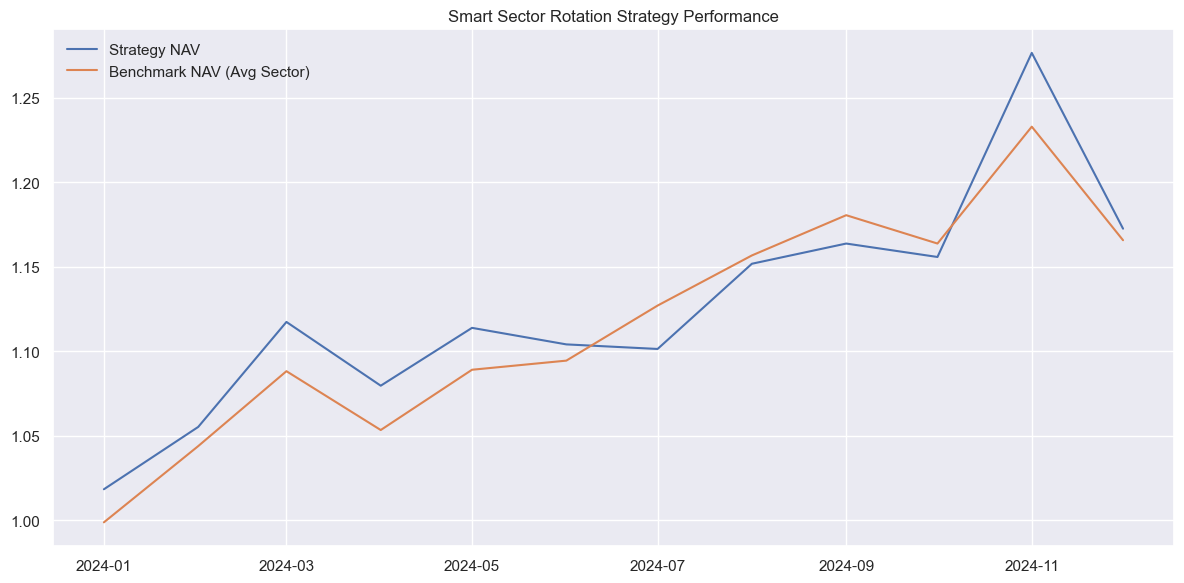

In [124]:
# === 7. Plot Results ===
plt.figure(figsize=(12, 6))
plt.plot(strategy_nav, label='Strategy NAV')
plt.plot(benchmark_nav, label='Benchmark NAV (Avg Sector)')
plt.title('Smart Sector Rotation Strategy Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [125]:
# === 8. Evaluation ===
accuracy = (y_pred == y_test).mean().mean()
print(f"Model average accuracy: {accuracy:.2%}")

Model average accuracy: 60.83%
